<a href="https://colab.research.google.com/github/ProtossDragoon/Deep-Learning-with-Python/blob/main/chapter8_%EC%83%9D%EC%84%B1%EB%AA%A8%EB%8D%B8%EC%9D%84%EC%9C%84%ED%95%9C%EB%94%A5%EB%9F%AC%EB%8B%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 작성 : 2020/12/30

- 이 notebook 은 SAI I Team 의 '케라스 창시자에게 배우는 딥러닝' 스터디 참고/멘토링 자료 목적으로 제작되었습니다.
- 이 notebook 을 학습하고자 할 때, 해당 주차의 책을 모두 공부한 후 따라가는 것을 매우 추천합니다.
- 이 코드와 주석에 설명되어있지 않다고 중요하지 않은 내용인 것은 아닙니다. 반드시 책을 선행해 주세요.
- 제작자 github : https://github.com/ProtossDragoon
- 질문 올리는 곳 : 
- 2020년 SAI 동아리원분들께서는, https://github.com/sju-coml/SAI-2020-Team-I/issues 에 질문을 올려주세요.
- contact : dlwkdgn1@naver.com / dlwkdgn3@gmail.com

### Timeline

- 2021.01.04 chapter 8-3 Neural Style Transfer 작성 완료

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

## Neural Style Transfer

여러분들이 시작부터 어려움을 겪었을 Neural Style Transfer 을 중심으로, 하나하나 설명을 드리고자 합니다. LSTM 은 기존 컨셉에서 크게 달라지지 않아서, 설명할거리가 많지 않지만 - 갑자기 나오는 이 Style Transfer 을 어려워하실 분들이 많을 것 같습니다. 집중하고 시작해 봅시다!

In [ ]:
# style 은 참고 이미지와 가깝게 하라!
# content 는 원래 이미지에서 보존해라!


# concept
# loss = distance(style(reference_image) - style(generated_image)) + distance(content(original_image) - content(generated_image))
# 예라이... 말이 쉽지!

idea
- deep (convolutional) neural network 에서 앞단 (=하위 층) 의 activation 은 pattern 과 같은 "국부적인" 정보에 활성화된다.
- 뒷단 (=상위 층) 의 activation 은 "전역적이고 추상화된" 정보에 활성화된다.

<br>

이건 다 알죠? chapter 5 convnet 할 때 정말정말 많이 나왔던 내용이고, 많은 분들이 발표도 해 주셨습니다.

<br>

solution
- style 의 손실을 수학적으로 담기 위해, "국부적인" 앞단 (=하위 층) 의 activation 을 활용한다.
- content 의 손실을 수학적으로 담기 위해, "전역적이고 추상화된" 뒷단 (=상위 층) 의 activation 을 활용한다.

<br>

In [ ]:
try:
  # This %tensorflow_version magic only works in Colab.
  %tensorflow_version 1.x
except Exception:
  pass

# For your non-Colab code, be sure you have tensorflow==1.15
import tensorflow as tf
assert tf.__version__.startswith('1')
print(tf.__version__)

TensorFlow 1.x selected.
1.15.2


시작하기 전에 VGG19가 어떻게 생긴 모델인지 구경이나 해 봅시다!

In [ ]:
tf.keras.backend.clear_session() # 이 코드의 정확한 의미는 나중에 이해합시다.
backbone = tf.keras.applications.VGG19(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
backbone.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
80142336/80134624 [==============================] - 2s 0us/step
Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 1

### API 문서 미리보기

- 제가 이 튜토리얼을 작성하는 동안에는 텐서플로우 공식 API 문서 페이지에 404 error 가 뜨며 잘 작동하지 않았습니다.
- 개발을 하다 보면 이런 경우가 종종 나타납니다. 이럴 때에는 당황하지 마시고 python 원본 코드를 찾아보면 됩니다.
- tensorflow 공식 홈페이지의 문서들은, 실제 소스 코드의 주석을 바탕으로 자동으로 만들어진 것이랍니다.
- 이 말은 곧 실제 코드에 주석이 있다는 말이겠지요!
- https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/keras/backend.py
- chapter 8 을 진행하기 위해 책에 작성되어 있는 코드들에 등장하는 함수들의 공식 문서이므로, 코드가 이해되지 않을 때 다시 돌아오도록 합시다.

In [ ]:
# def K.batch_flatten()
  """Turn a nD tensor into a 2D tensor with same 0th dimension.
  In other words, it flattens each data samples of a batch.

  Args:
      x: A tensor or variable.

  Returns:
      A tensor.

  Examples:
    Flattening a 3D tensor to 2D by collapsing the last dimension.
    >>> x_batch = tf.keras.backend.ones(shape=(2, 3, 4, 5))
    >>> x_batch_flatten = batch_flatten(x_batch)
    >>> tf.keras.backend.int_shape(x_batch_flatten)
    (2, 60)
  """


In [ ]:
# def K.permute_dimensions()
  """Permutes axes in a tensor.

  Args:
      x: Tensor or variable.
      pattern: A tuple of
          dimension indices, e.g. `(0, 2, 1)`.

  Returns:
      A tensor.
      
  Example:
    >>> a = tf.constant([[1, 2, 3], [4, 5, 6], [7, 8, 9], [10, 11, 12]])
    >>> a
    <tf.Tensor: shape=(4, 3), dtype=int32, numpy=
    array([[ 1,  2,  3],
           [ 4,  5,  6],
           [ 7,  8,  9],
           [10, 11, 12]], dtype=int32)>
    >>> tf.keras.backend.permute_dimensions(a, pattern=(1, 0))
    <tf.Tensor: shape=(3, 4), dtype=int32, numpy=
    array([[ 1,  4,  7, 10],
           [ 2,  5,  8, 11],
           [ 3,  6,  9, 12]], dtype=int32)>
  """

In [ ]:
# def K.dot()
  """Multiplies 2 tensors (and/or variables) and returns a tensor.
  This operation corresponds to `numpy.dot(a, b, out=None)`.

  Args:
      x: Tensor or variable.
      y: Tensor or variable.

  Returns:
      A tensor, dot product of `x` and `y`.
      
  Examples:
    If inputs `x` and `y` are 2-D arrays, then it is equivalent to `tf.matmul`.
    >>> x = tf.keras.backend.placeholder(shape=(2, 3))
    >>> y = tf.keras.backend.placeholder(shape=(3, 4))
    >>> xy = tf.keras.backend.dot(x, y)
    >>> xy
    <KerasTensor: shape=(2, 4) dtype=float32 ...>
    >>> x = tf.keras.backend.placeholder(shape=(32, 28, 3))
    >>> y = tf.keras.backend.placeholder(shape=(3, 4))
    >>> xy = tf.keras.backend.dot(x, y)
    >>> xy
    <KerasTensor: shape=(32, 28, 4) dtype=float32 ...>
    If `x` is an N-D array and `y` is an M-D array (where M>=2), it is a sum
    product over the last axis of `x` and the second-to-last axis of `y`.
    >>> x = tf.keras.backend.random_uniform_variable(shape=(2, 3), low=0, high=1)
    >>> y = tf.keras.backend.ones((4, 3, 5))
    >>> xy = tf.keras.backend.dot(x, y)
    >>> tf.keras.backend.int_shape(xy)
    (2, 4, 5)
  """

### Loss 정의하기

아래 내용들은 주석이 달려 있다고 해도 충분히 어려울 수 있습니다! 너무 걱정하지 마세요. 저도 어려웠거든요. <br>
침착하게, 각 내용을 이해하려고 노력을 해 보세요. 이것이 가장 중요합니다. <br>
그리고 나서 모르겠다고 생각하는 내용, 잘못되었다고 생각하는 내용은 issue 에 언제든지 업로드해주세요.

In [ ]:
# 코드가 굉장히 헷갈리게 생겼는데 책에 힌트가 많이 부족합니다.
# 이해를 돕기 위해 주석을 자세히 달겠습니다.
# 책의 소스 코드와 다를 수 있습니다.

In [ ]:
from tensorflow.keras import backend as K 
# 어지간하면, 여러분들의 모듈의 계층 이해에 대한 연습을 위해 as 구문을 사용하지 않지만, 이번 장에서는 너무 자주 사용되므로 as 구문을 사용해 단순화합니다.

In [ ]:
def _gram_matrix(x):
    # tip
    # 정말 헷갈리는 것은, 종종 함수를 짤 때, 배치를 포함해서 작성할 것인가 (batch, h, w, ch) 또는 배치를 포함하지 않고 작성할 것인가 (h, w, ch)
    # 이에 따라서 처리하는 과정이 많이 달라진다는 점입니다. 이 함수는, batch 차원을 생각하지 않고, _gram_matrix 함수의 input 으로 (h, w, ch) 를 사용한 듯 합니다.
    # 왜 그런지 생각을 해 보면서 아래 내용을 이제 살펴봅시다.
    # 아래 코드가 이해가 됐다면, (batch, h, w, ch) 가 x 의 input 이라고 생각할 때에 발생하는 문제에 대해서도 고민을 해 봅시다.

    # 함수 정의 : 위 API 문서와 비슷한 형식으로 설명을 작성해 보았습니다. shape 에 주목해 보세요.
    """
    _gram_matrix(x)

    Args:
        x: tensor (shape : (h, w, ch))
    
    Returns:
        gram: gram matrix (shape : (ch, ch))
    """

    permuted_features = K.permute_dimensions(x, (2, 0, 1)) # np.transpose 와 완전히 똑같은 기능입니다. 쫄지 마세요! (ch, h, w) 로 바꾸어 줍니다.
    permuted_features = K.batch_flatten(permuted_features) # 책에 나와 있듯, (ch, h*w) 로 변경하는 코드입니다.

    gram = K.dot(permuted_features, K.transpose(permuted_features)) # (ch, h*w) (h*w, ch) = (ch, ch) 
    # 왜 이렇게 동작할까요? API 문서를 보면, 2D matrix 둘을 dot 으로 처리하는 경우 matmul (행렬 곱) 과 동일하게 동작하기 때문입니다.

    return gram

In [ ]:
def _style_loss(base, combination):
    # concept
    # style 은 참고 이미지와 가깝게 하라!

    # 함수 정의
    """
    _style_loss(x)

    Args:
        base: 가져오고 싶은 스타일의 tensor (shape : (h, w, ch))
        combination: 스타일이 가미된 tensor (shape : (h, w, ch))
    
    Returns:
        normarlized_style_loss: style loss (shape : scalar)
    """

    S = _gram_matrix(base)
    C = _gram_matrix(combination)
    
    channels = 3
    size = img_height * img_width
    
    normalized_style_loss = K.sum(K.square(S-C)) / ((4.)*(channels**2)*(size**2))

    # (size**2)
    # 하나의 gram matrix 을 만든다면, 그 shape 은 [ch, ch] 입니다.
    # 이 [ch, ch] 행렬 G 의 하나의 셀 G_ij 를 만들기 위해서는 두 벡터 (1, h*w) (1, h*w) 내적이 사용되었습니다.
    # 따라서, 이는 h 와 w 의 size 가 변하면 항상 변하게 되는 것이지요.
    # 이를 적절히 보정해 주기 위해서는 (h*w)**2 로 나누어 주는 작업이 필요합니다.
    # -
    # (channels**2)
    # ch 의 값이 커짐에 따라서, [ch, ch] 행렬 G 의 하나의 셀 G_ij 마다의 중요도가 다르게 해석되기 때문에, 이를 균일하게 해 주는 역할입니다.
    # 예를 들어, 3차원 벡터 a = (0.1, 1.3, 2.0) 가 있습니다. 각 원소 a_i 는 해당 index i 의 중요도라고 생각해 봅시다.
    # 또, 6차원 벡터 b = (0.1, 1.3, 2.0, 5.3, 9.0, 10.3) 가 있습니다. 마찬가지로 각 원소 b_i 는 해당 index i 의 중요도라고 생각해 봅시다.
    # a 의 2.0 이 벡터 전체에서 차지하는 중요도와 b 의 2.0 이 벡터 전체에서 차지하는 중요도는 엄연히 다릅니다.
    # 이를 적절히 보정해 주기 위해서, a 벡터 각 원소를 a 의 차원 수 (3) 로 나누어 주고, b 의 각 원소를 b 의 차원 수 (6) 으로 나누어 준다면, 상대적 의미가 동일하게 됩니다.
    # 따라서, channels**2 를 gram matrix 전체에 나누어 줌으로써 상대적 의미를 균일하게 해 줄 수 있습니다.
    # -
    # (4.)
    # 4 는 별 의미 없습니다. 그냥 4를 더 나누어 보니까 잘 되더라. 정도로 해석하면 됩니다.
    # 컨퍼런스 콜 중에, YOLO loss 를 보여 주면서, 다양한 항들 사이에서 균형을 맞추어 주는 람다값 기억나시죠? 그런 역할이라고 생각하면 된답니다~

    return normalized_style_loss

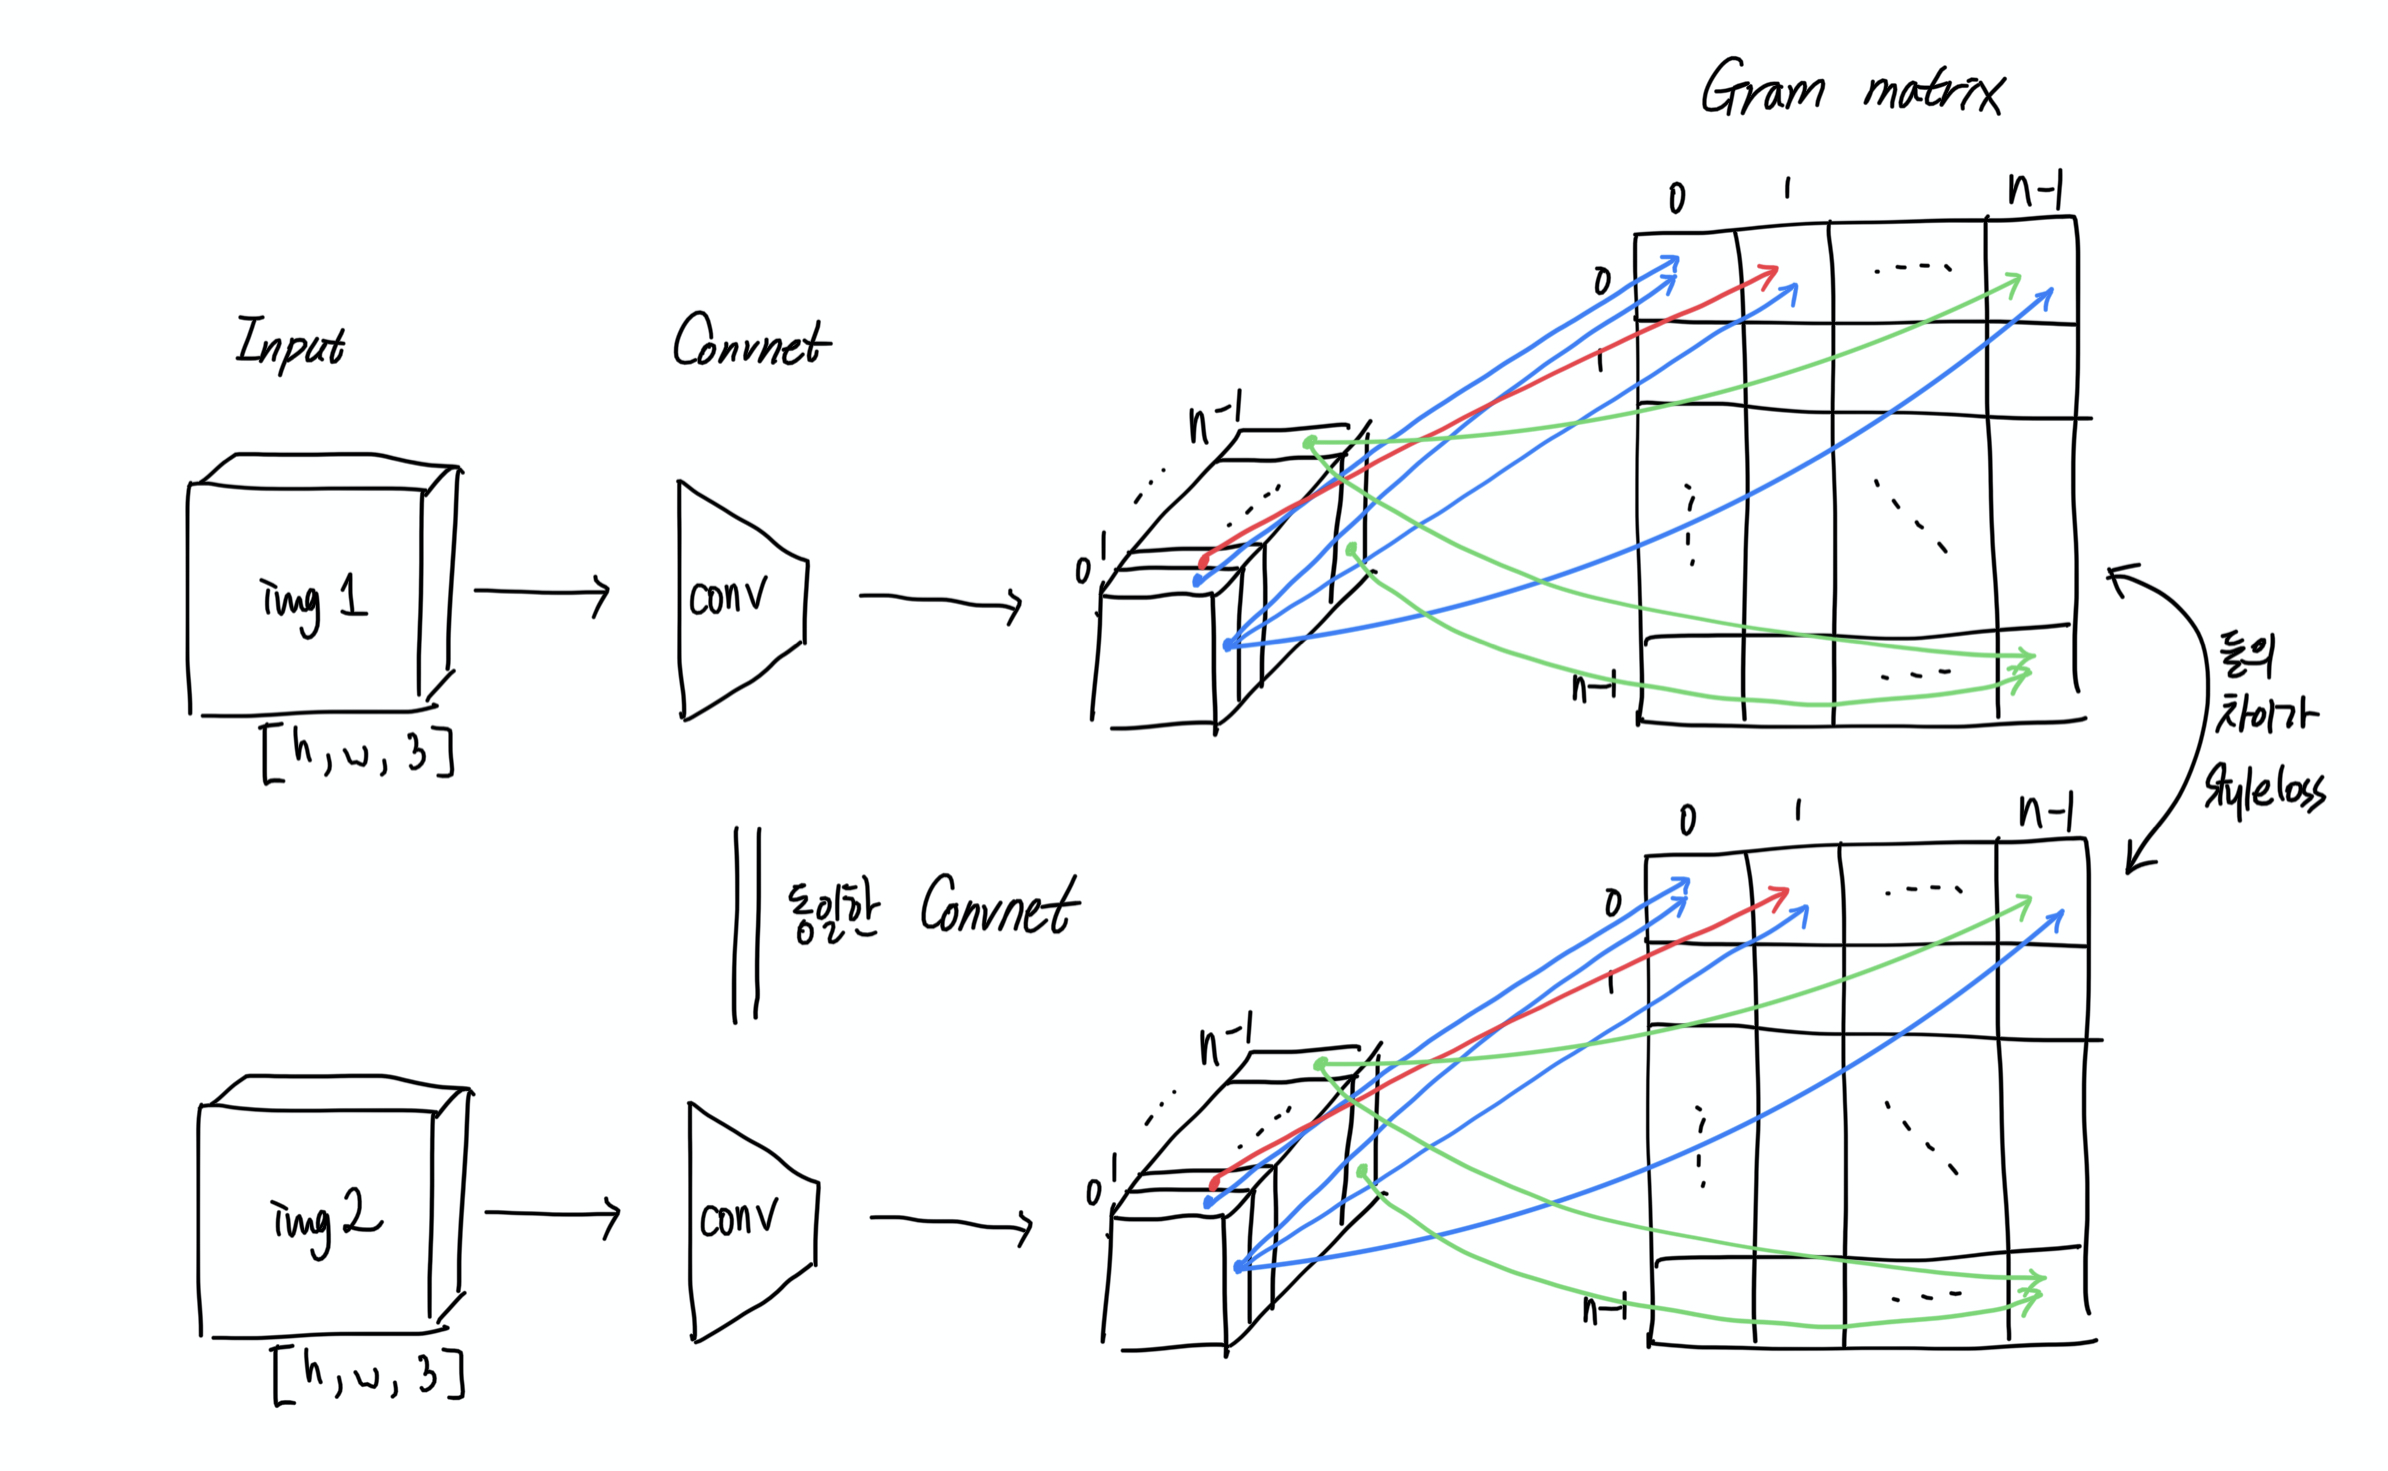

[그림1] 위 그림에서 하나의 화살표는 하나의 채널 전체를 의미합니다. 화살표 두 개가 만나는 지점은, 두 화살표에 해당하는 채널 요소 전체를 element-wise multiplication 한 뒤 모든 요소를 더하는 것을 의미합니다.

In [ ]:
def _content_loss(base, combination):
    # concept
    # content 는 원래 이미지 (base) 에서 보존해라!
    # 따라서, 원래 base 와 combination 의 content 의 차이가 많이 날수록 많이 혼내야 한다.

    # 함수 정의
    """
    _content_loss(base, combination)

    Args:
        base: tensor (shape : (h, w, ch))
        combination: tensor (shape : (h, w, ch))
    
    Returns:
        content_loss: content loss (shape : scalar)
    """

    content_loss = tf.keras.backend.sum(tf.keras.backend.square(base - combination))
    return content_loss

In [ ]:
def _total_variation_loss(x, generated_image_width, generated_image_height):
    # concept
    # 결과물에 지나친 격자무늬를 없애려면, 이웃한 픽셀 간 픽셀값 차이가 적어야 한다.
    # 따라서, 차이가 많이 나면 날수록, 많이 혼내야 한다.
    
    # tip
    # 정말 헷갈리는 것은, 종종 함수를 짤 때, 배치를 포함해서 작성할 것인가 (batch, h, w, ch) 또는 배치를 포함하지 않고 작성할 것인가 (h, w, ch)
    # 이에 따라서 처리하는 과정이 많이 달라진다는 점입니다. 이 함수는, _gram_matrix 함수 및 다른 함수들과 다르게 argument 으로 (batch, h, w, ch) 를 사용한 듯 합니다.

    # 함수 정의
    """
    _total_variation_loss(base, combination)

    Args:
        x: tensor (shape : (batch, h, w, ch))
        generated_image_width: 우리 모델에서 만들어내고자 하는 스타일 변환 이미지 결과물의 width
        generated_image_height: 우리 모델에서 만들어내고자 하는 스타일 변환 이미지 결과물의 height
    
    Returns:
        variation_loss: smoothing loss loss (shape : scalar)
    """    

    img_width  = generated_image_width
    img_height = generated_image_height

    a = K.square(x[:,  :img_height-1,  :img_width-1, :] - # 원본 이미지를 오른쪽 아래로 한칸 민 이미지에서
                 x[:, 1:            ,  :img_width-1, :])  # 원본 이미지를 오른쪽 위로 한칸 민 이미지를 비교함
    b = K.square(x[:,  :img_height-1,  :img_width-1, :] - # 원본 이미지를 오른쪽 아래로 한칸 민 이미지에서
                 x[:,  :img_height-1, 1:           , :])  # 원본 이미지를 왼쪽 아래로 한칸 민 이미지를 비교함

    # a.shape : (1, h-1, w-1, 3)
    # b.shape : (1, h-1, w-1, 3)

    # 질의응답
    # Q : 엥? 코드를 보면 온전히 그런 표현이 아니고 변두리가 잘리는데요? 
    # A : 그정도는 무시할 수 있을 정도로 작습니다. 또한 변두리에 smoothing 이 들어가도 좋은 의미를 가지기는 어렵다. 
    #     하나 더, 모든 케이스를 다 커버하기 위해서 다른 연산들이 추가되면 늘어난 연산 대비 성능 효용이 크지 않을 수 있다.

    variation_loss = K.sum(K.pow(a + b, 1.25))
    # (1.25)
    # 4 는 별 의미 없습니다. 그냥 1.25 라는 값을 사용해 보니까 잘 되더라. 정도로 해석하면 됩니다.
    # 컨퍼런스 콜 중에, YOLO loss 를 보여 주면서, 다양한 항들 사이에서 균형을 맞추어 주는 람다값 기억나시죠? 그런 역할이라고 생각하면 된답니다~

    return variation_loss

이제, loss 정의를 마치기 전에 input pipeline 설계를 먼저 해 봅시다. 아래 코드가 이해되나요?

<br>

여러분이 어려워하거나 이해가 되지 않았을만한 내용을 두 가지 제시해 보고자 합니다.

In [ ]:
tf.keras.backend.clear_session() # 이 코드의 정확한 의미는 나중에 이해합시다.

placeholder = K.placeholder()


vgg19_model = tf.keras.applications.VGG19(include_top=False, weights="imagenet", input_tensor=placeholder) # 모델 생성

each_layers_activations = []
for layer in vgg19_model.layers:
    print(layer.name, layer.output)
    each_layers_activations.append( (layer.name, layer.output) )
each_layers_activations = dict(each_layers_activations) # 딕셔너리 형태로 변환

SyntaxError: ignored

하나.

난데없이 나타난 placeholder, 이게 뭘까요? 정확히 이해하기 위해서는 Keras 의 내부에서 돌아가고 있는 tensorflow 의 computation graph 를 이해할 필요가 있습니다. 이 내용이 궁금하신 분들은, 따로 서칭을 해 보세요. 신경망의 모든 요소들은 placeholder, constant, variable 들과 tf.ops 사이의 연산들로 이루어져 있다는 것이 tensorflow 1 의 원칙입니다. 그림을 간단히 그려 보면 아래와 같은 모양이 됩니다. (이런 느낌이 나온다는 것을 보여주고자 했던 것이니, 그림 요소 하나하나에 너무 신경쓰지는 마세요.)

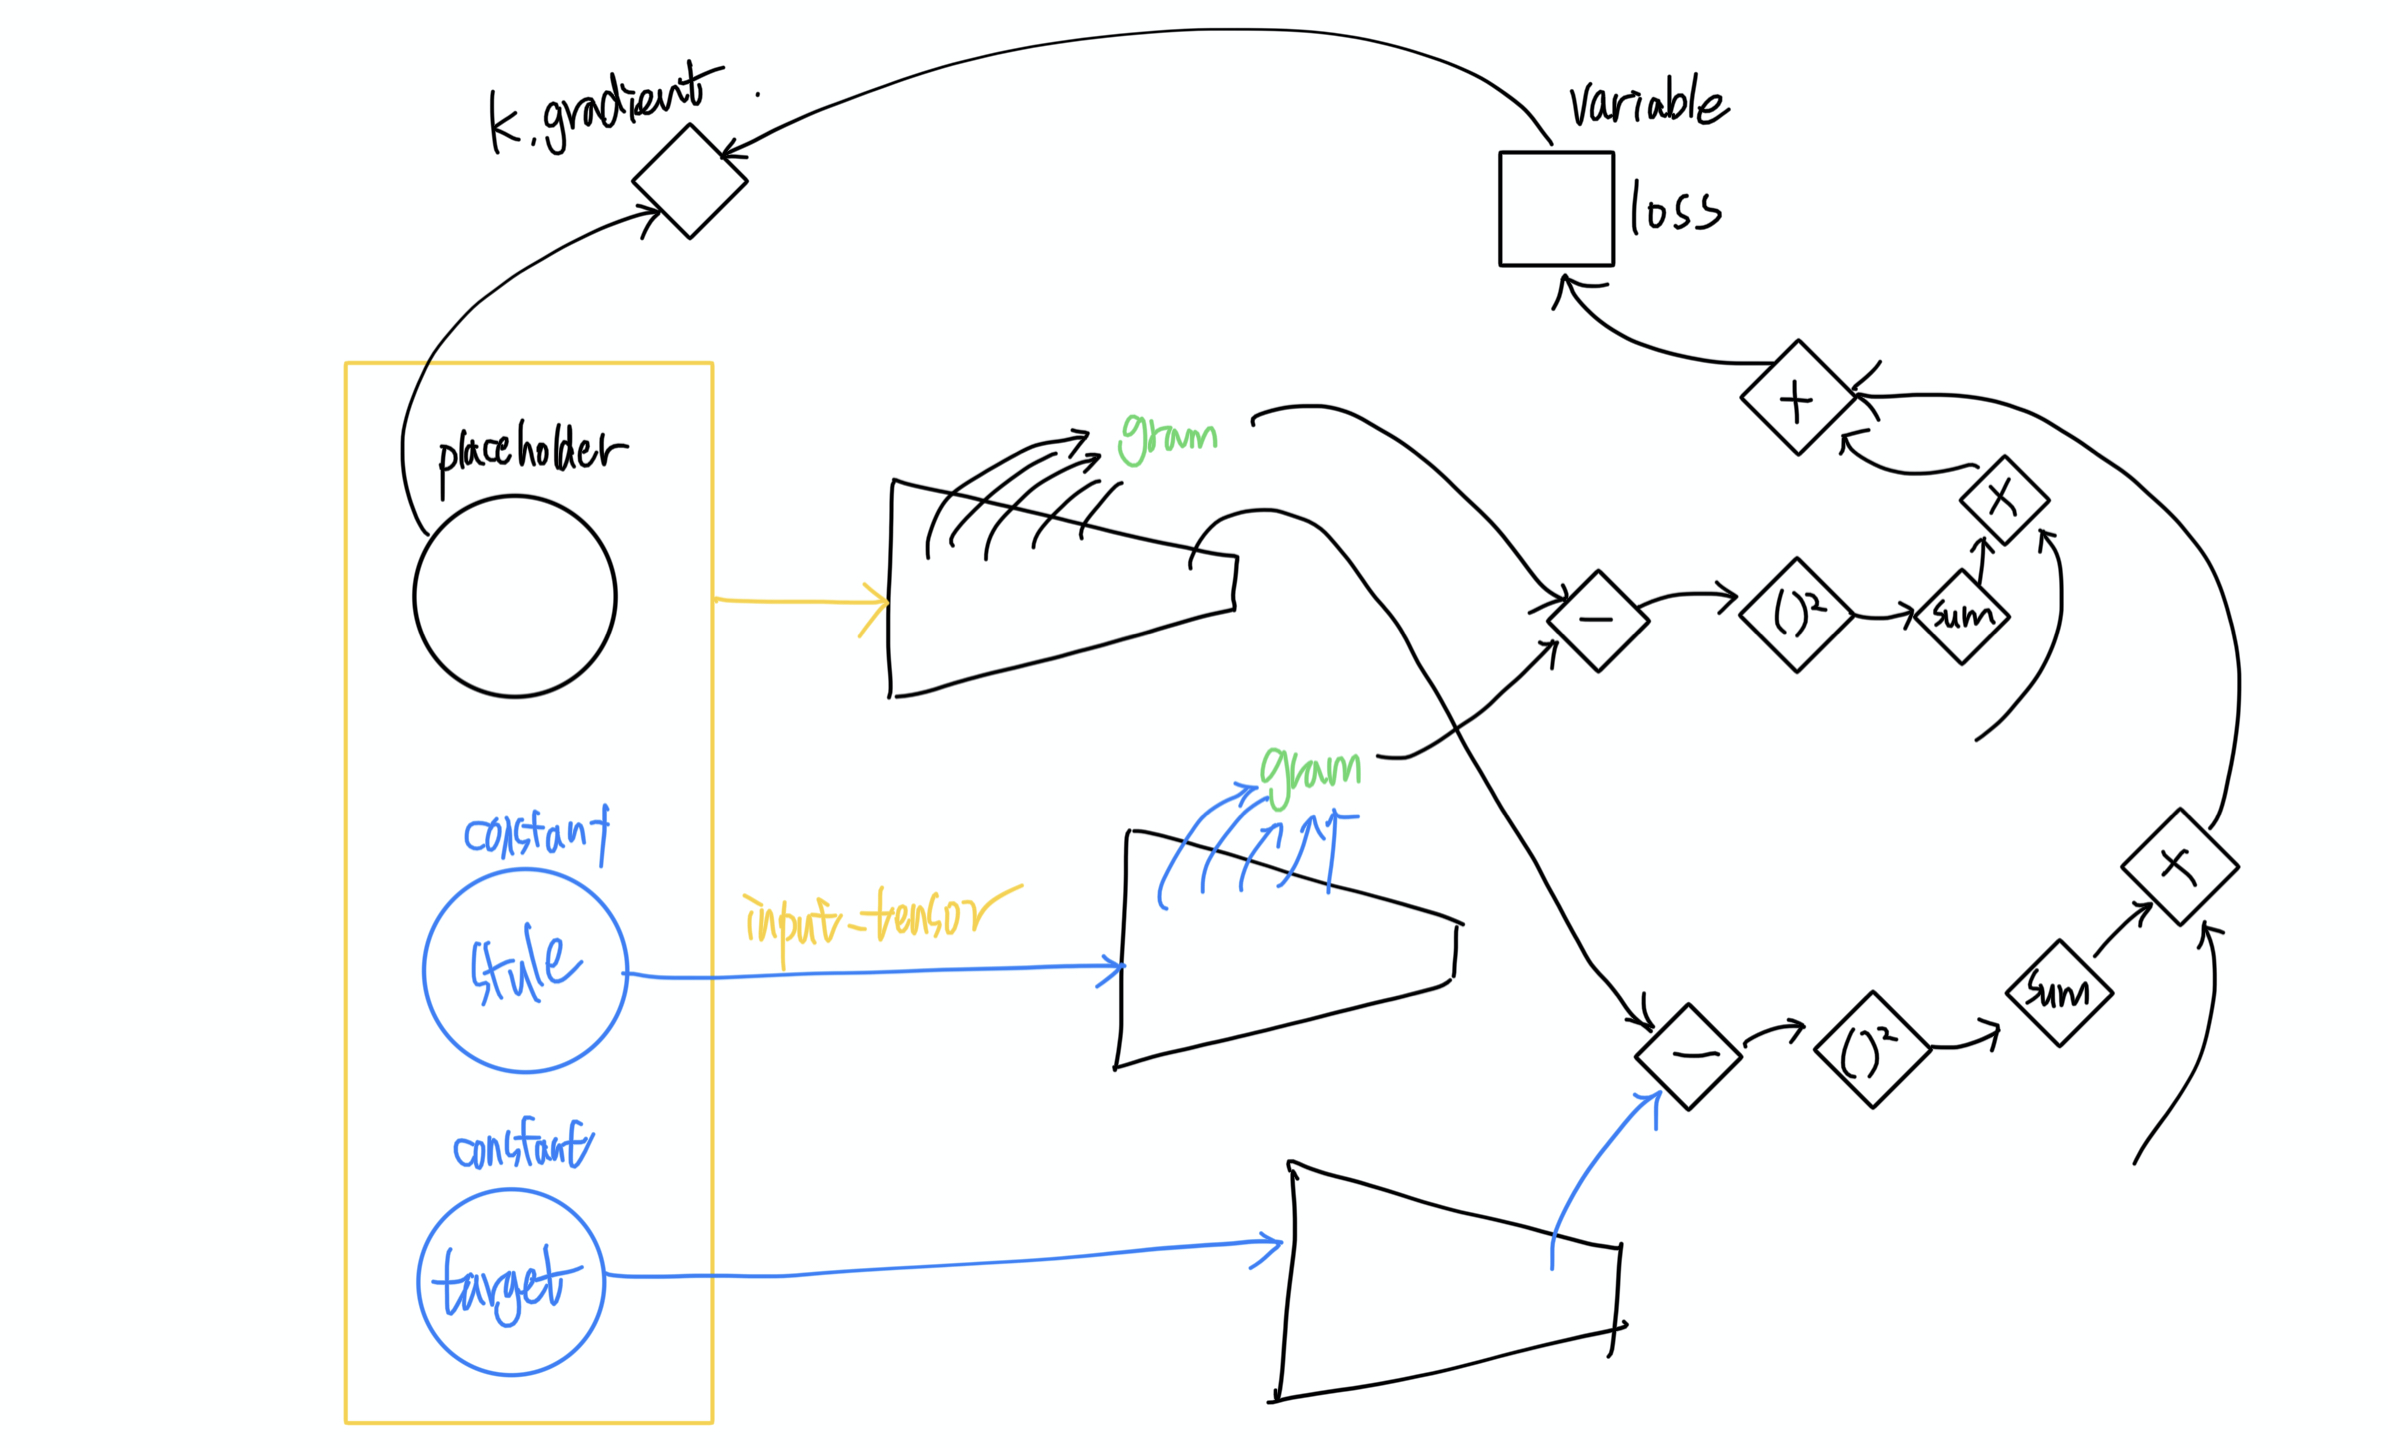

둘.

<br>

위에서 설명했던 [그림1] 을 보면, 다른 이미지를 동일한 네트워크에 투입하는 것을 볼 수 있습니다. 이것을 실제로 어떻게 구현할 수 있을까요? 바로 배치 차원을 활용해서입니다. 아래 그림을 봅시다. n 개의 배치가 하나의 컨벌루션 신경망을 통과한다고 할 때, 모두 동일한 상태의 신경망을 통과하는 것이 됩니다. n 개의 배치만큼, 신경망이 복사된다고 생각하는 것이 정확합니다. 이를 통해, 소스코드에서 신경망을 여러 개 만들고, 각 신경망으로부터 특징을 추출한 뒤 조합하지 않고, 배치 차원으로 이미지를 쌓아 네트워크에 통과시킴으로써 문제를 해결합니다.




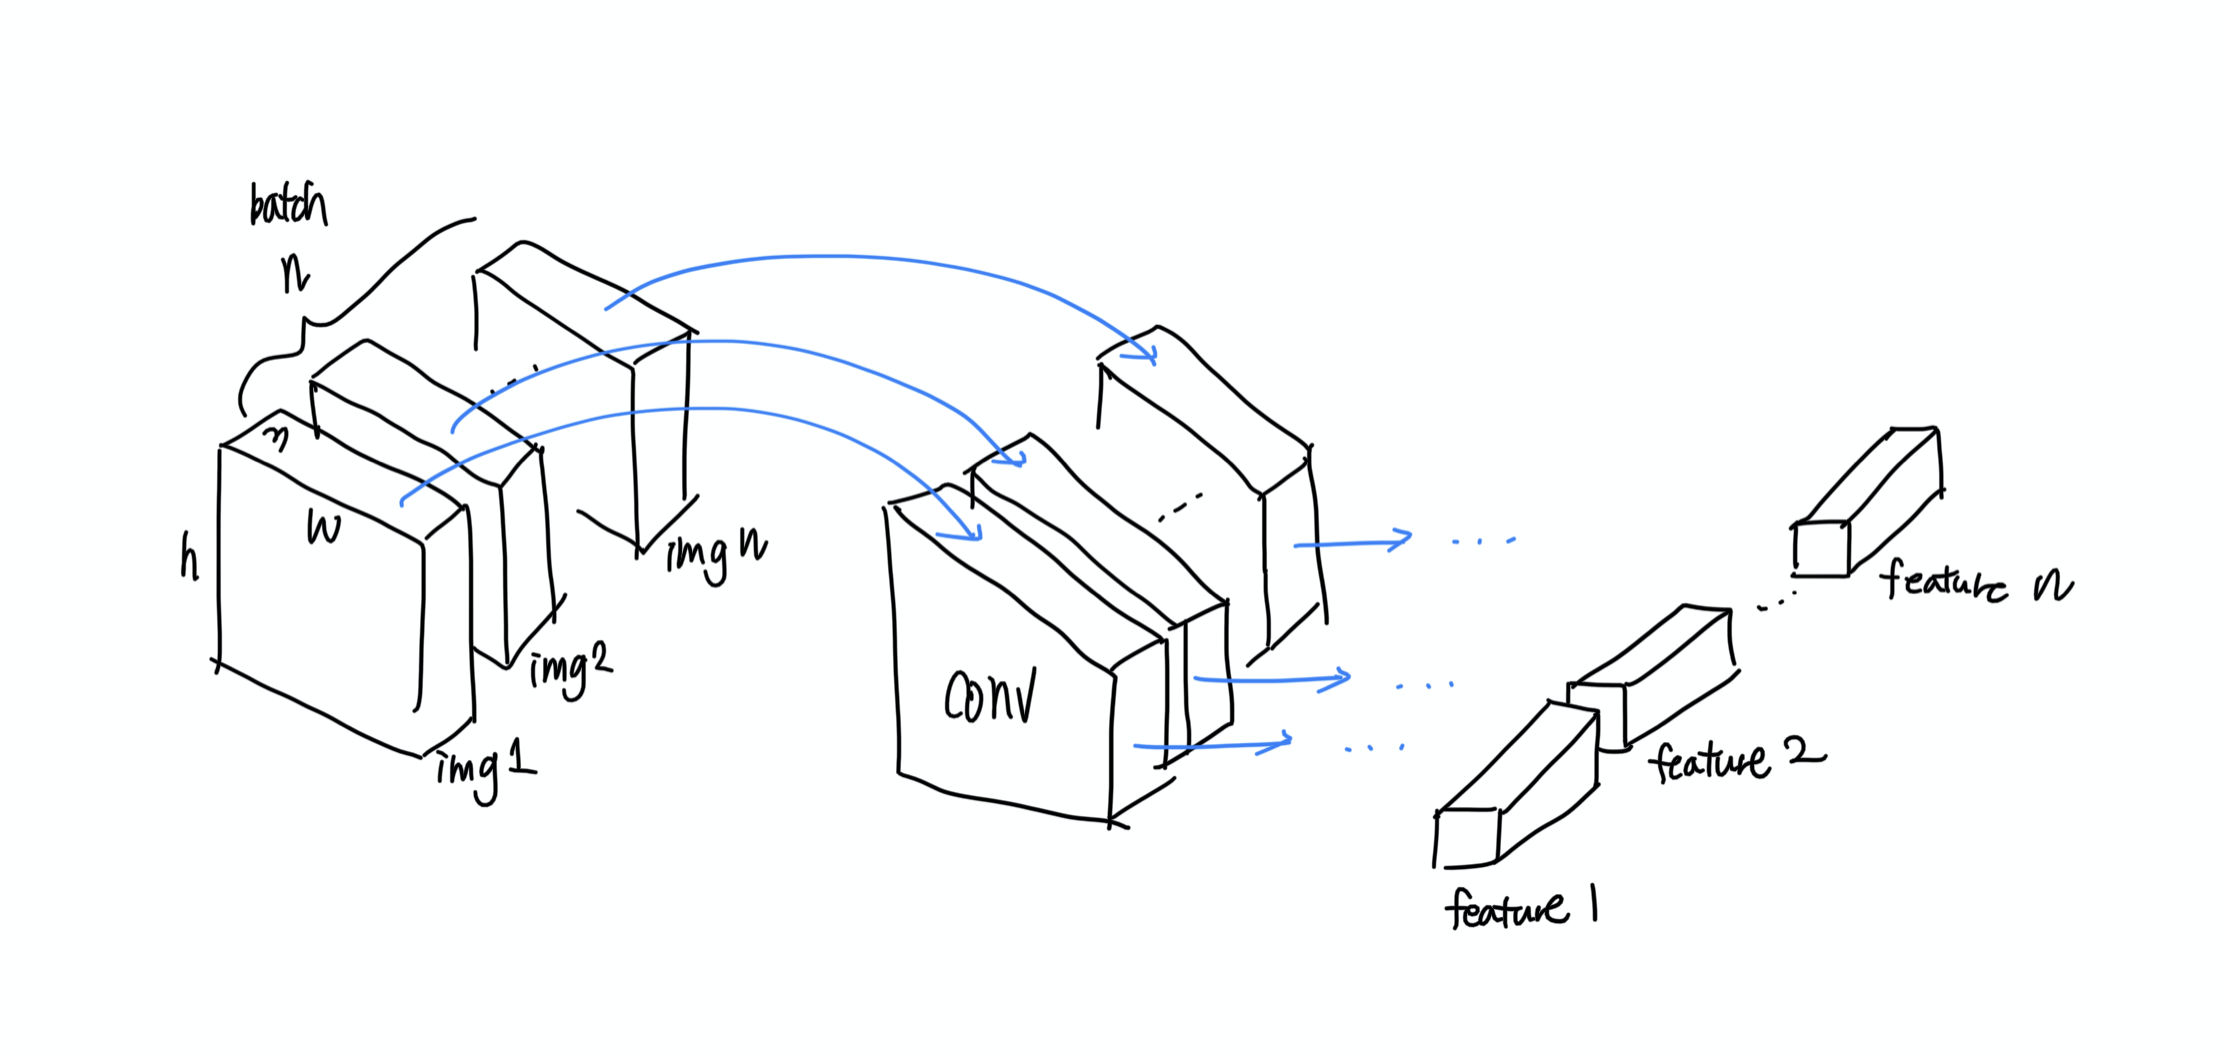

In [ ]:
layer_for_content_loss = 'block5_conv2'
layers_for_style_loss = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']

total_variation_loss_weight = 1e-4
style_loss_weight = 1
content_loss_weight = 0.025

input tensor 을 생각합시다.
- 0번째 배치 : content 를 참고할 이미지
- 1번째 배치 : style 을 참고할 이미지
- 2번째 배치 : 내가 만들어내고자 하는 이미지. content 를 유지하며 style 을 가져와야 합니다.

In [ ]:
loss = K.variable(0.)

In [ ]:
# content loss 를 정의하는데 필요한 layer 들의 특징을 준비합니다.
layer_features = each_layers_activations[layer_for_content_loss]
target_content_image_features = layer_features[0, :, :, :] # 0번째 배치에 해당하는 결과물 : target image 의 content feature 입니다.
combination_content_image_feature = layer_features[2, :, :, :] # 2번째 배치에 해당하는 결과물 : 만들어내고자 하는 image 의 content feature 입니다.

# content loss 를 정의합니다.
loss = loss + (content_loss_weight * _content_loss(target_content_image_features, combination_content_image_feature))

In [ ]:
# style loss 를 정의하는데 필요한 layer 들의 특징을 준비합니다.
for layer_for_style in layers_for_style_loss:
    layer_features = each_layers_activations[layer_for_style]
    target_style_image_features = layer_features[1, :, :, :] # 0번째 배치에 해당하는 결과물 : target image 의 style feature 입니다.
    combination_style_image_feature = layer_features[2, :, :, :] # 2번째 배치에 해당하는 결과물 : 만들어내고자 하는 image 의 style feature 입니다.

    # style loss 를 더해 줍니다.
    loss = loss + (style_loss_weight * _style_loss(target_style_image_features, combination_style_image_feature)) / len(layers_for_style_loss)

In [ ]:
# 마지막으로, variation loss 를 더해 줍니다.
loss = loss + total_variation_loss_weight * _total_variation_loss())

위까지만 이해하는 것도 상당히 어려웠을 것이라고 생각합니다. <br>
여러분이 우선 전체를 진행하고 나서, 다시 생각해볼만한 거리를 제공하고자 합니다. <br>
예전에 우리가 LSTM 을 배울 때, 정말 다양한 gate 들이 있었던 것을 기억하나요? <br>
실제로는 각 gate 들이 어떤 역할을 할 것이라고 단정지을 수 없습니다. <br>
단지 논리적으로 생각을 표현하고 (이런 게이트를 저런 방식으로 표현하면, 역전파를 하면서 이렇게 수렴하지 않을까?) 역전파에게 모든 것을 맡기는 것이지요. 이를 "표현공간을 다양하게 만드는 것" 이라고 책에서는 서술했습니다. <br>

<br>

생성 모델에서는 어떨까요? <br>
생성 모델에서도, loss 를 주입하는 output tensor 의 각 부분이, 실제로 어떤 부분을 담당하는지 전혀 이해하고 있지 않습니다. 그런데도 어떻게 이런 일이 일어나는 것일까요? 이에 대한 답을 하자면, '정말 많은 데이터로부터 그냥 조금씩 들어맞는 방향으로 가다 보니... 그렇게 됐어' 라고 설명할 수밖에 없습니다. 이런 궁금증을 가진 채로 인공지능을 공부하면, '어떻게 저렇게 loss 를 설계하는 아이디어를 냈을까?' 라는 관점에서 재밌는 생각들이 많이 들지 않을까 싶네요 :) <br>


NameError: ignored

### BFGS 알고리즘 이해하기

<br>

굳이 이해하려고 하는 호기심덩어리들을 위해 읽어야 할 문서들 정리

1. https://darkpgmr.tistory.com/149 : 최적화 이론이 어떻게 발전하고, 어떤 경향들이 있었는지 꼼꼼하게 살펴보세요. 컨셉을 정확히 이해하려면 위부터 천천히 맨 아래까지 전부 읽는 것을 추천합니다. (저도 읽고 있습니다.)
  - [선택, 영어] 중간에 테일러 급수와 관련된 내용이 나오는데, 역시 이런 개념 설명은 https://youtu.be/3d6DsjIBzJ4 이 가장 잘 합니다.
  - [선택] https://darkpgmr.tistory.com/142 : 수식이 강조된 부가설명